## This kernel is from [@Abhishek Thakur](https://www.kaggle.com/abhishek) youtube channel

### [Bengali.AI: Handwritten Grapheme Classification Using PyTorch (Part-1)](https://www.youtube.com/watch?v=8J5Q4mEzRtY) 

### [Bengali.AI: Handwritten Grapheme Classification Using PyTorch (Part-2)](https://www.youtube.com/watch?v=uZalt-weQMM&t=3478s)

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import joblib
import glob
from PIL import Image
from PIL.Image import fromarray
from tqdm import tqdm 

import torch
import cv2
import torch.nn as nn
from torch.nn import functional as F

import sklearn.metrics
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
# import fastai
# from fastai.vision import *
# from fastai.callbacks import SaveModelCallback
# import cv2
import os
from sklearn.model_selection import KFold
# from RAdam import *
# from CSVLogger import *
# from Mish import *

# from pytorchtools import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0,'over9000')
# PATH = '/content/EfficientNet-PyTorch/efficientnet_pytorch'
# sys.path.insert(0,f'{PATH}')


In [3]:
# %%writefile create_folds.py

# import pandas as pd
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# if __name__ == "__main__":
#     df = pd.read_csv("train.csv")
#     print(df.head())
#     df.loc[:, 'kfold'] = -1

#     df = df.sample(frac=1).reset_index(drop=True)

#     X = df.image_id.values
#     y = df[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values

#     mskf = MultilabelStratifiedKFold(n_splits=5)

#     for fold, (trn_, val_) in enumerate(mskf.split(X, y)):
#         print("TRAIN: ", trn_, "VAL: ", val_)
#         df.loc[val_, "kfold"] = fold

#     print(df.kfold.value_counts())
#     df.to_csv("train_folds.csv", index=False)

In [4]:
# %%writefile create_image_pickles.py

# import pandas as pd
# import joblib
# import glob
# from tqdm import tqdm

# if __name__ == "__main__":
#     files = glob.glob("train_*.parquet")
#     for f in files:
#         df = pd.read_parquet(f)
#         image_ids = df.image_id.values
#         df = df.drop("image_id", axis=1)
#         image_array = df.values
#         for j, image_id in tqdm(enumerate(image_ids), total=len(image_ids)):
#             joblib.dump(image_array[j, :], f"image_pickles/{image_id}.pkl")


244.4629469256464
244.90340838797476
243.98329828034144
246.10036496350364
236.9629778547569
246.81040455276505
240.32416800692812
245.8463441791414
237.54806383768403
239.55616726462947


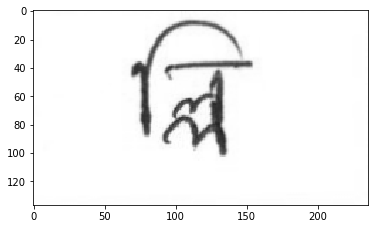

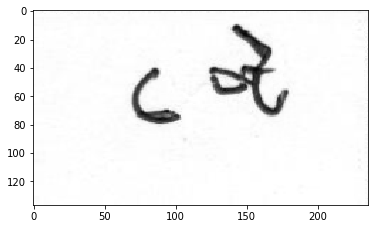

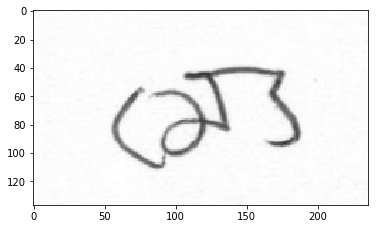

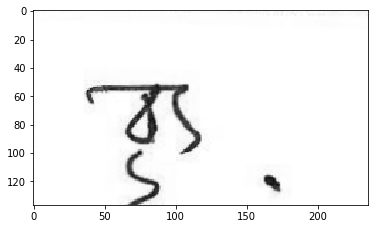

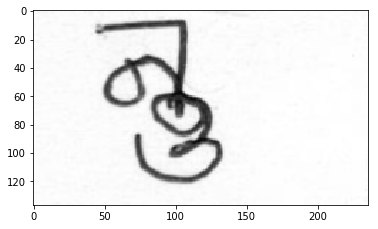

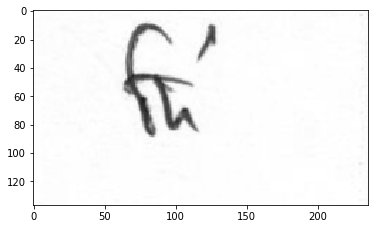

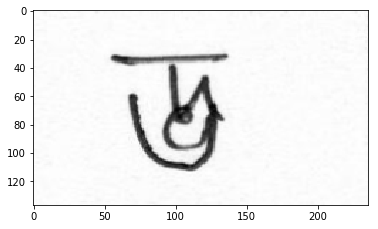

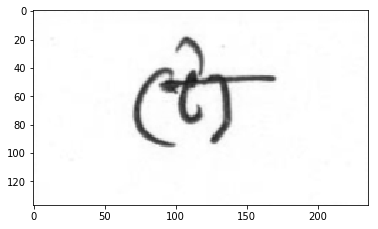

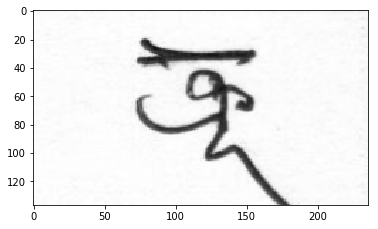

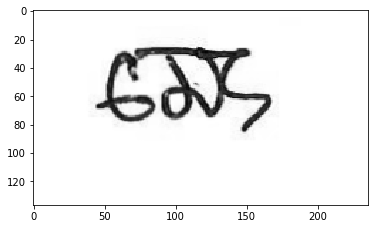

In [5]:
df = pd.read_csv("train_folds.csv")
image_ids = df.image_id.values
for idx in range (10):
    image = joblib.load(f"image_pickles/{image_ids[idx]}.pkl")
#     image = 255 - image.reshape(137, 236).astype(np.uint8)
#     image = (image*(255.0/image.max())).astype(np.uint8)
    image = image.reshape(137,236).astype(float)
#     image = crop_resize(image)
    print(np.mean(image))
    image = Image.fromarray(image).convert("RGB")
    plt.figure()
    plt.imshow(image)

In [6]:
# %%writefile dataset.py

import pandas as pd
import albumentations
import joblib
import numpy as np
import torch

from PIL import Image

class BengaliDatasetTrain:
    def __init__(self, folds, img_height, img_width, mean, std):
        df = pd.read_csv("train_folds.csv")
        df = df[["image_id", "grapheme_root", "vowel_diacritic", "consonant_diacritic", "kfold"]]

        df = df[df.kfold.isin(folds)].reset_index(drop=True)
        
        self.image_ids = df.image_id.values
        self.grapheme_root = df.grapheme_root.values
        self.vowel_diacritic = df.vowel_diacritic.values
        self.consonant_diacritic = df.consonant_diacritic.values

        if len(folds) == 1:
            self.aug = albumentations.Compose([
                albumentations.Resize(img_height, img_width, always_apply=True),
                albumentations.Normalize(mean, std, always_apply=True)
            ])
        else:
            self.aug = albumentations.Compose([
                albumentations.Resize(img_height, img_width, always_apply=True),
                albumentations.Normalize(mean, std, always_apply=True),
                albumentations.ShiftScaleRotate(shift_limit=0.0625,
                                               scale_limit=0.1, 
                                               rotate_limit=10,
                                               p=0.5),
                albumentations.Cutout(num_holes=9,  max_h_size=18, max_w_size=18,fill_value=0, p=0.5),
#                 albumentations.CoarseDropout(max_holes=8, max_height=20, max_width=20,fill_value=255, p=0.25),
                albumentations.OneOf([
                        albumentations.MotionBlur(p=1),
                        albumentations.MedianBlur(blur_limit=3, p=1),
                        albumentations.Blur(blur_limit=3, p=1),
                    ], p=0.3),
                albumentations.OneOf([
                        albumentations.OpticalDistortion(p=0.3),
                        albumentations.GridDistortion(p=.1),
                        albumentations.ElasticTransform(sigma=50, alpha=1, alpha_affine=10,p=0.2),
                    ], p=0.25),
#                 albumentations.OneOf([
#                         albumentations.RandomContrast(0.25),
#                         albumentations.RandomBrightness(0.25),
#                     ], p=0.25),
            ])


    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, item):
        image = joblib.load(f"image_pickles/{self.image_ids[item]}.pkl")
        image = image.reshape(137, 236).astype(float)
        image = Image.fromarray(image).convert("RGB")
        image = self.aug(image=np.array(image))["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)

        return {
            "image": torch.tensor(image, dtype=torch.float),
            "grapheme_root": torch.tensor(self.grapheme_root[item], dtype=torch.long),
            "vowel_diacritic": torch.tensor(self.vowel_diacritic[item], dtype=torch.long),
            "consonant_diacritic": torch.tensor(self.consonant_diacritic[item], dtype=torch.long)
        }


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.2665179
2.0698678
1.937383
2.0107386
2.1363049
1.9713737
2.1156604
1.9246019
2.019776


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

2.082016
2.2855537
2.184231
2.1083822
2.0350404
1.9748026
2.0371723
2.1400137
2.2432446
1.9463634


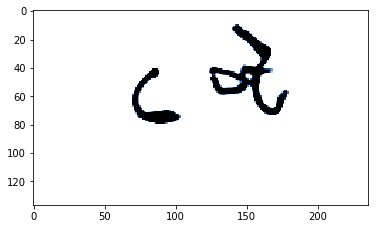

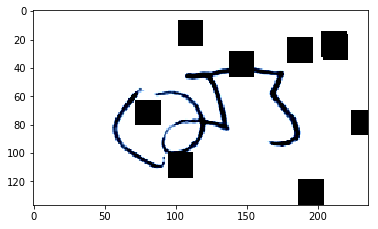

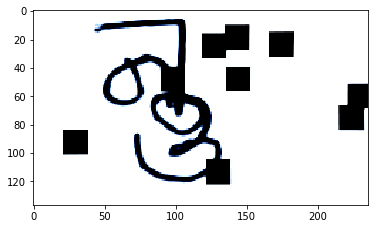

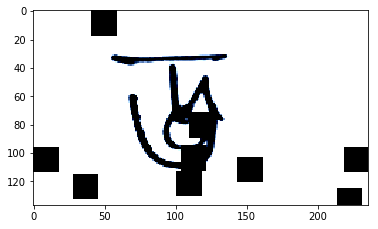

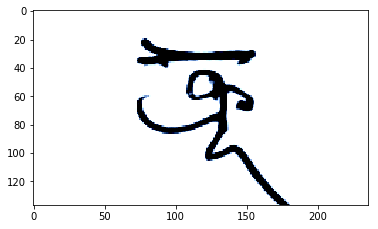

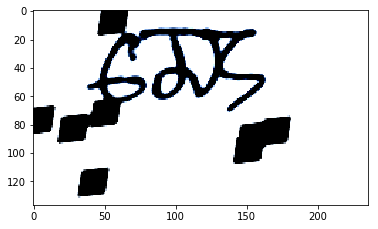

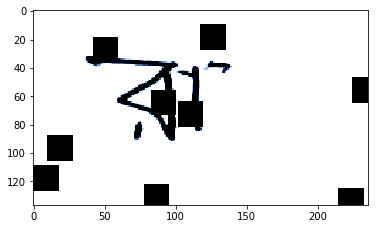

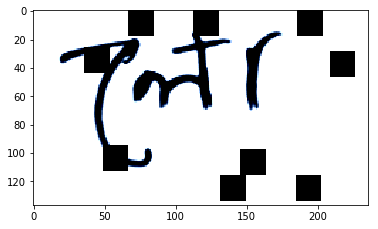

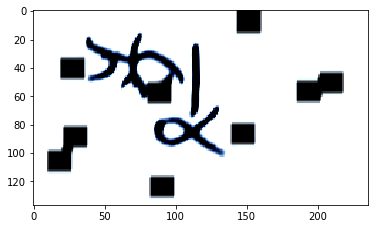

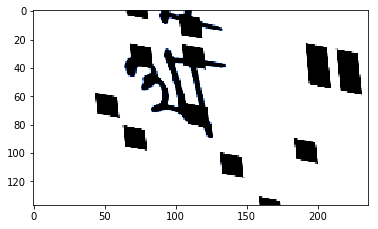

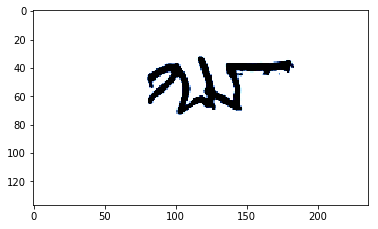

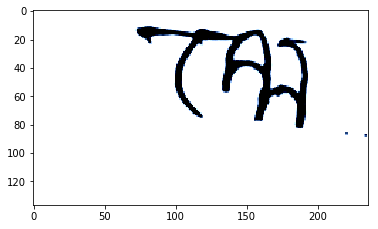

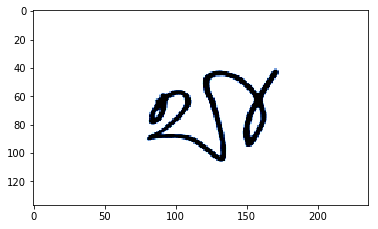

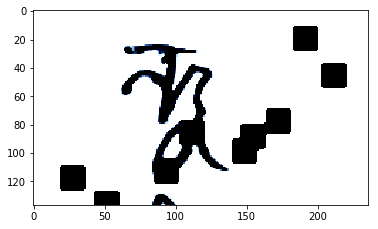

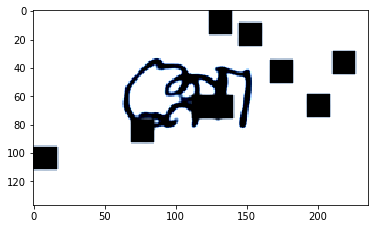

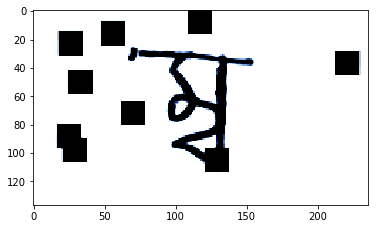

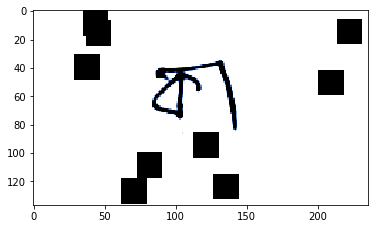

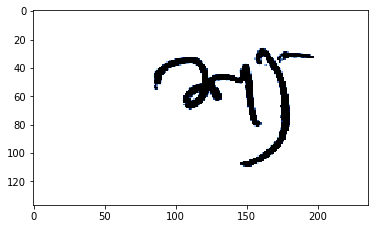

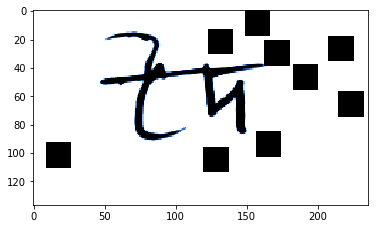

In [7]:
dataset = BengaliDatasetTrain ( folds=[0,1],
                                img_height=137,
                                img_width=236,
                                mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225),
                                )

for idx in range(1,20): 
    img = dataset[idx]["image"]
#     print(dataset[idx]["grapheme_root"])
#     print(dataset[idx]["vowel_diacritic"])
#     print(dataset[idx]["consonant_diacritic"])
    npimg = img.numpy()
    print(np.mean(npimg))
    plt.figure()
    plt.imshow(np.transpose(npimg,(1,2,0)))

In [8]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b4')
model

Loaded pretrained weights for efficientnet-b4


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [9]:
import sys
sys.path.insert(0,'over9000')
from radam import RAdam
from over9000 import Over9000

In [10]:
# %%writefile models.py

# import pretrainedmodels
import torch.nn as nn
from torch.nn import functional as F

class EfficientNet_b0(nn.Module):

  def __init__(self,pretrained):
    super(EfficientNet_b0,self).__init__()
    if pretrained is True:
      self.model = EfficientNet.from_pretrained('efficientnet-b0')
    else:
      self.model = EfficientNet.from_name('efficientnet-b0')
    self.l0 = nn.Linear(1280,168)
    self.l1 = nn.Linear(1280,11)
    self.l2 = nn.Linear(1280,7)
  
  def forward(self,inputs):
    bs,_,_,_=inputs.shape
    x=self.model.extract_features(inputs)
    x = F.adaptive_avg_pool2d(x,1).reshape(bs,-1)
    l0 = self.l0(x)
    l1 = self.l1(x)
    l2 = self.l2(x)
    return l0,l1,l2


In [11]:
# %%writefile models.py

# import pretrainedmodels
import torch.nn as nn
from torch.nn import functional as F

class EfficientNet_b4(nn.Module):

  def __init__(self,pretrained):
    super(EfficientNet_b4,self).__init__()
    if pretrained is True:
      self.model = EfficientNet.from_pretrained('efficientnet-b4')
    else:
      self.model = EfficientNet.from_name('efficientnet-b4')
    self.l0 = nn.Linear(1792,168)
    self.l1 = nn.Linear(1792,11)
    self.l2 = nn.Linear(1792,7)
  
  def forward(self,inputs):
    bs,_,_,_=inputs.shape
    x=self.model.extract_features(inputs)
    x = F.adaptive_avg_pool2d(x,1).reshape(bs,-1)
    l0 = self.l0(x)
    l1 = self.l1(x)
    l2 = self.l2(x)
    return l0,l1,l2


In [12]:
# %%writefile models.py

# import pretrainedmodels
import torch.nn as nn
from torch.nn import functional as F

class EfficientNet_b5(nn.Module):

  def __init__(self,pretrained):
    super(EfficientNet_b5,self).__init__()
    if pretrained is True:
      self.model = EfficientNet.from_pretrained('efficientnet-b5')
    else:
      self.model = EfficientNet.from_name('efficientnet-b5')
    self.l0 = nn.Linear(2048,168)
    self.l1 = nn.Linear(2048,11)
    self.l2 = nn.Linear(2048,7)
  
  def forward(self,inputs):
    bs,_,_,_=inputs.shape
    x=self.model.extract_features(inputs)
    x = F.adaptive_avg_pool2d(x,1).reshape(bs,-1)
    l0 = self.l0(x)
    l1 = self.l1(x)
    l2 = self.l2(x)
    return l0,l1,l2


In [13]:
# %%writefile models.py

# import pretrainedmodels
import torch.nn as nn
from torch.nn import functional as F

class EfficientNet_b6(nn.Module):

  def __init__(self,pretrained):
    super(EfficientNet_b6,self).__init__()
    if pretrained is True:
      self.model = EfficientNet.from_pretrained('efficientnet-b6')
    else:
      self.model = EfficientNet.from_name('efficientnet-b6')
    self.l0 = nn.Linear(2304,168)
    self.l1 = nn.Linear(2304,11)
    self.l2 = nn.Linear(2304,7)
  
  def forward(self,inputs):
    bs,_,_,_=inputs.shape
    x=self.model.extract_features(inputs)
    x = F.adaptive_avg_pool2d(x,1).reshape(bs,-1)
    l0 = self.l0(x)
    l1 = self.l1(x)
    l2 = self.l2(x)
    return l0,l1,l2


In [14]:
# %%writefile model_dispatcher.py

# import models

# MODEL_DISPATCHER = {
#     "EfficientNet_b4": models.EfficientNet_b4
# }  

In [15]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


In [16]:
# %%writefile train.py

import os
import ast
import torch
import torch.nn as nn
import numpy as np
import sklearn.metrics

# from model_dispatcher import MODEL_DISPATCHER
# from dataset import BengaliDatasetTrain
from tqdm import tqdm
# from pytorchtools import EarlyStopping


DEVICE = "cuda"
IMG_HEIGHT=137
IMG_WIDTH=236
EPOCHS=20
TRAIN_BATCH_SIZE=32
TEST_BATCH_SIZE=32
MODEL_MEAN=(0.485, 0.456, 0.406)
MODEL_STD=(0.229, 0.224, 0.225)
BASE_MODEL="resnet34"
TRAINING_FOLDS_CSV="train_folds.csv"
ALL_FOLDS = [[(1,2,3,4),(0,)]]#,[(0,1,3,4),(1,)]]#,[(0,2,3,4),(2,)],[(0,1,2,4),(3,)],[(0,1,2,3),(4,)]]
# TRAINING_FOLDS_CSV = os.environ.get("TRAINING_FOLDS_CSV")

# IMG_HEIGHT = int(os.environ.get("IMG_HEIGHT"))
# IMG_WIDTH = int(os.environ.get("IMG_WIDTH"))
# EPOCHS = int(os.environ.get("EPOCHS"))

# TRAIN_BATCH_SIZE = int(os.environ.get("TRAIN_BATCH_SIZE"))
# TEST_BATCH_SIZE = int(os.environ.get("TEST_BATCH_SIZE"))

# MODEL_MEAN = ast.literal_eval(os.environ.get("MODEL_MEAN"))
# MODEL_STD = ast.literal_eval(os.environ.get("MODEL_STD"))

# TRAINING_FOLDS = ast.literal_eval(os.environ.get("TRAINING_FOLDS"))
# VALIDATION_FOLDS = ast.literal_eval(os.environ.get("VALIDATION_FOLDS"))
# BASE_MODEL = os.environ.get("BASE_MODEL")



def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, 'f'total {final_score}, y {y.shape}')
    
    return final_score


def loss_fn(outputs, targets):
    o1, o2, o3 = outputs
    t1, t2, t3 = targets
    l1 = nn.CrossEntropyLoss()(o1, t1)
    l2 = nn.CrossEntropyLoss()(o2, t2)
    l3 = nn.CrossEntropyLoss()(o3, t3)
    return (2*l1 + l2 + l3) / 4



def train(dataset, data_loader, model, optimizer):
    model.train()
    final_loss = 0
    counter = 0
    final_outputs = []
    final_targets = []

    for bi, d in tqdm(enumerate(data_loader), total=int(len(dataset)/data_loader.batch_size)):
        counter = counter + 1
        image = d["image"]
        grapheme_root = d["grapheme_root"]
        vowel_diacritic = d["vowel_diacritic"]
        consonant_diacritic = d["consonant_diacritic"]

        image = image.to(DEVICE, dtype=torch.float)
        grapheme_root = grapheme_root.to(DEVICE, dtype=torch.long)
        vowel_diacritic = vowel_diacritic.to(DEVICE, dtype=torch.long)
        consonant_diacritic = consonant_diacritic.to(DEVICE, dtype=torch.long)
        
#         print(image.shape)

        optimizer.zero_grad()
        outputs = model(image)
        targets = (grapheme_root, vowel_diacritic, consonant_diacritic)
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        final_loss += loss

        o1, o2, o3 = outputs
        t1, t2, t3 = targets
        final_outputs.append(torch.cat((o1,o2,o3), dim=1))
        final_targets.append(torch.stack((t1,t2,t3), dim=1))

        #if bi % 10 == 0:
        #    break
    final_outputs = torch.cat(final_outputs)
    final_targets = torch.cat(final_targets)

    print("==========================Train=============================")
    macro_recall_score = macro_recall(final_outputs, final_targets)
    
    return final_loss/counter , macro_recall_score



def evaluate(dataset, data_loader, model):
    with torch.no_grad():
        model.eval()
        final_loss = 0
        counter = 0
        final_outputs = []
        final_targets = []
        for bi, d in tqdm(enumerate(data_loader), total=int(len(dataset)/data_loader.batch_size)):
            counter = counter + 1
            image = d["image"]
            grapheme_root = d["grapheme_root"]
            vowel_diacritic = d["vowel_diacritic"]
            consonant_diacritic = d["consonant_diacritic"]

            image = image.to(DEVICE, dtype=torch.float)
            grapheme_root = grapheme_root.to(DEVICE, dtype=torch.long)
            vowel_diacritic = vowel_diacritic.to(DEVICE, dtype=torch.long)
            consonant_diacritic = consonant_diacritic.to(DEVICE, dtype=torch.long)

            outputs = model(image)
            targets = (grapheme_root, vowel_diacritic, consonant_diacritic)
            loss = loss_fn(outputs, targets)
            final_loss += loss

            o1, o2, o3 = outputs
            t1, t2, t3 = targets
            #print(t1.shape)
            final_outputs.append(torch.cat((o1,o2,o3), dim=1))
            final_targets.append(torch.stack((t1,t2,t3), dim=1))
        
        final_outputs = torch.cat(final_outputs)
        final_targets = torch.cat(final_targets)

        print("=======================Valid============================")
        macro_recall_score = macro_recall(final_outputs, final_targets)

    return final_loss/counter , macro_recall_score

In [17]:
def main():
    for x in ALL_FOLDS:
        TRAINING_FOLDS=x[0]
        VALIDATION_FOLDS=x[1]
        model = EfficientNet_b6(pretrained=False)
        model.load_state_dict(torch.load("WEIGHTS_b5_Adamsss_0.pth"))
        model.to(DEVICE)

        train_dataset = BengaliDatasetTrain(
            folds=TRAINING_FOLDS,
            img_height = IMG_HEIGHT,
            img_width = IMG_WIDTH,
            mean = MODEL_MEAN,
            std = MODEL_STD
        )

        train_loader = torch.utils.data.DataLoader(
            dataset=train_dataset,
            batch_size= TRAIN_BATCH_SIZE,
            shuffle=True,
            num_workers=12
        )

        valid_dataset = BengaliDatasetTrain(
            folds=VALIDATION_FOLDS,
            img_height = IMG_HEIGHT,
            img_width = IMG_WIDTH,
            mean = MODEL_MEAN,
            std = MODEL_STD
        )

        valid_loader = torch.utils.data.DataLoader(
            dataset=valid_dataset,
            batch_size= TEST_BATCH_SIZE,
            shuffle=True,
            num_workers=12
        )

#         optimizer = RAdam(model.parameters(), lr=1e-3)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                                mode="min", 
                                                                patience=3, 
                                                                factor=0.1,verbose=True)

        early_stopping = EarlyStopping(patience=5, verbose=True)

        #if torch.cuda.device_count() > 1:
        #    model = nn.DataParallel(model)

        best_score = -1

        print("FOLD : ", VALIDATION_FOLDS[0] )

        for epoch in range(1, EPOCHS+1):

            train_loss, train_score = train(train_dataset,train_loader, model, optimizer)
            torch.cuda.empty_cache()
            val_loss, val_score = evaluate(valid_dataset, valid_loader, model)
            torch.cuda.empty_cache()
            scheduler.step(val_loss)
            torch.cuda.empty_cache()


            if val_score > best_score:
                best_score = val_score
                torch.save(model.state_dict(), f"WEIGHTS_b5_Adamsss_{VALIDATION_FOLDS[0]}.pth")

            epoch_len = len(str(EPOCHS))
            print_msg = (f'[{epoch:>{epoch_len}}/{EPOCHS:>{epoch_len}}] ' +
                         f'train_loss: {train_loss:.5f} ' +
                         f'train_score: {train_score:.5f} ' +
                         f'valid_loss: {val_loss:.5f} ' +
                         f'valid_score: {val_score:.5f}'
                        )

            print(print_msg)

            early_stopping(val_score, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break


if __name__ == "__main__":
    main()

FOLD :  0


100%|██████████| 5021/5021 [1:01:06<00:00,  1.37it/s]


==========================Train=============================
recall: grapheme 0.9854067661751669, vowel 0.9927611445193734, consonant 0.9911980320441407, total 0.988693177228462, y (160672, 3)


1256it [03:54,  5.37it/s]                          


=======================Valid============================
recall: grapheme 0.9675074085138297, vowel 0.9890400397734097, consonant 0.9873683349414157, total 0.9778557979356213, y (40168, 3)
[ 1/20] train_loss: 0.03557 train_score: 0.98869 valid_loss: 0.07839 valid_score: 0.97786
Validation loss decreased (inf --> 0.977856).  Saving model ...


100%|██████████| 5021/5021 [1:01:10<00:00,  1.37it/s]


==========================Train=============================
recall: grapheme 0.9854746340931281, vowel 0.9929323717376749, consonant 0.9916386833007057, total 0.9888800808061592, y (160672, 3)


1256it [03:57,  5.39it/s]                          


=======================Valid============================
recall: grapheme 0.9674831385284027, vowel 0.9890108318382986, consonant 0.9874177596044821, total 0.9778487171248966, y (40168, 3)
[ 2/20] train_loss: 0.03552 train_score: 0.98888 valid_loss: 0.07844 valid_score: 0.97785
Validation loss decreased (0.977856 --> 0.977849).  Saving model ...


100%|██████████| 5021/5021 [1:01:08<00:00,  1.38it/s]


==========================Train=============================
recall: grapheme 0.9851611058896965, vowel 0.9926686831210614, consonant 0.9916368063173537, total 0.9886569253044521, y (160672, 3)


1256it [03:57,  5.40it/s]                          


=======================Valid============================
recall: grapheme 0.9678128565659079, vowel 0.9889253368902016, consonant 0.9880141195633632, total 0.9781412923963451, y (40168, 3)
[ 3/20] train_loss: 0.03622 train_score: 0.98866 valid_loss: 0.07840 valid_score: 0.97814
EarlyStopping counter: 1 out of 5


 10%|▉         | 495/5021 [06:04<54:53,  1.37it/s]  

KeyboardInterrupt: 

In [1]:
# %%writefile run.sh

# export IMG_HEIGHT=137
# export IMG_WIDTH=236
# export EPOCHS=50
# export TRAIN_BATCH_SIZE=64
# export TEST_BATCH_SIZE=64
# export MODEL_MEAN="(0.485, 0.456, 0.406)"
# export MODEL_STD="(0.229, 0.224, 0.225)"
# export BASE_MODEL="resnet34"
# export TRAINING_FOLDS_CSV="../input/train_folds.csv"


# export TRAINING_FOLDS="(0,1,2,3)"
# export VALIDATION_FOLDS="(4,)"
# python3 train.py

# export TRAINING_FOLDS="(0,1,2,4)"
# export VALIDATION_FOLDS="(3,)"
# python3 train.py

# export TRAINING_FOLDS="(0,1,3,4)"
# export VALIDATION_FOLDS="(2,)"
# python3 train.py

# export TRAINING_FOLDS="(0,2,3,4)"
# export VALIDATION_FOLDS="(1,)"
# python3 train.py

# export TRAINING_FOLDS="(1,2,3,4)"
# export VALIDATION_FOLDS="(0,)"
# python3 train.py

# Inference

In [8]:
import sys
pt_models = "../input/pretrained-models/pretrained-models.pytorch-master/"
sys.path.insert(0, pt_models)
import pretrainedmodels

In [9]:
import glob
import torch
import albumentations
import pandas as pd
import numpy as np

from tqdm import tqdm
from PIL import Image
import joblib
import torch.nn as nn
from torch.nn import functional as F

In [10]:
MODEL_MEAN = (0.485, 0.456, 0.406)
MODEL_STD = (0.229, 0.224, 0.225)
IMG_HEIGHT = 137
IMG_WIDTH = 236
DEVICE="cuda"

In [12]:
class BengaliDatasetTest:
    def __init__(self, df, img_height, img_width, mean, std):
        
        self.image_ids = df.image_id.values
        self.img_arr = df.iloc[:, 1:].values

        self.aug = albumentations.Compose([
            albumentations.Resize(img_height, img_width, always_apply=True),
            albumentations.Normalize(mean, std, always_apply=True)
        ])


    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, item):
        image = self.img_arr[item, :]
        img_id = self.image_ids[item]
        
        image = image.reshape(137, 236).astype(float)
        image = Image.fromarray(image).convert("RGB")
        image = self.aug(image=np.array(image))["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        

        return {
            "image": torch.tensor(image, dtype=torch.float),
            "image_id": img_id
        }

In [13]:
def model_predict():
    g_pred, v_pred, c_pred = [], [], []
    img_ids_list = [] 
    
    for file_idx in range(4):
        df = pd.read_parquet(f"../input/bengaliai-cv19/test_image_data_{file_idx}.parquet")

        dataset = BengaliDatasetTest(df=df,
                                    img_height=IMG_HEIGHT,
                                    img_width=IMG_WIDTH,
                                    mean=MODEL_MEAN,
                                    std=MODEL_STD)

        data_loader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size= TEST_BATCH_SIZE,
            shuffle=False,
            num_workers=4
        )

        for bi, d in enumerate(data_loader):
            image = d["image"]
            img_id = d["image_id"]
            image = image.to(DEVICE, dtype=torch.float)

            g, v, c = model(image)
            #g = np.argmax(g.cpu().detach().numpy(), axis=1)
            #v = np.argmax(v.cpu().detach().numpy(), axis=1)
            #c = np.argmax(c.cpu().detach().numpy(), axis=1)

            for ii, imid in enumerate(img_id):
                g_pred.append(g[ii].cpu().detach().numpy())
                v_pred.append(v[ii].cpu().detach().numpy())
                c_pred.append(c[ii].cpu().detach().numpy())
                img_ids_list.append(imid)
        
    return g_pred, v_pred, c_pred, img_ids_list

In [14]:
model = ResNet34(pretrained=False)
TEST_BATCH_SIZE = 32

final_g_pred = []
final_v_pred = []
final_c_pred = []
final_img_ids = []

for i in range(5):
    model.load_state_dict(torch.load(f"../input/resnet34weights/resnet34_fold{i}.pth"))
    model.to(DEVICE)
    model.eval()
    g_pred, v_pred, c_pred, img_ids_list = model_predict()
    
    final_g_pred.append(g_pred)
    final_v_pred.append(v_pred)
    final_c_pred.append(c_pred)
    if i == 0:
        final_img_ids.extend(img_ids_list)

In [15]:
img_ids_list

['Test_0',
 'Test_1',
 'Test_2',
 'Test_3',
 'Test_4',
 'Test_5',
 'Test_6',
 'Test_7',
 'Test_8',
 'Test_9',
 'Test_10',
 'Test_11']

In [16]:
final_g = np.argmax(np.mean(np.array(final_g_pred), axis=0), axis=1)
final_v = np.argmax(np.mean(np.array(final_v_pred), axis=0), axis=1)
final_c = np.argmax(np.mean(np.array(final_c_pred), axis=0), axis=1)

In [17]:
final_img_ids

['Test_0',
 'Test_1',
 'Test_2',
 'Test_3',
 'Test_4',
 'Test_5',
 'Test_6',
 'Test_7',
 'Test_8',
 'Test_9',
 'Test_10',
 'Test_11']

In [18]:
predictions = []
for ii, imid in enumerate(final_img_ids):
    predictions.append((f"{imid}_grapheme_root", final_g[ii]))
    predictions.append((f"{imid}_vowel_diacritic", final_v[ii]))
    predictions.append((f"{imid}_consonant_diacritic", final_c[ii]))

In [19]:
sub = pd.DataFrame(predictions, columns=["row_id", "target"])

In [20]:
sub

,row_id,target
0,Test_0_grapheme_root,3
1,Test_0_vowel_diacritic,0
2,Test_0_consonant_diacritic,0
3,Test_1_grapheme_root,93
4,Test_1_vowel_diacritic,2
5,Test_1_consonant_diacritic,0
6,Test_2_grapheme_root,19
7,Test_2_vowel_diacritic,0
8,Test_2_consonant_diacritic,0
9,Test_3_grapheme_root,115


In [21]:
sub.to_csv("submission.csv", index=False)